In [11]:
import gc, argparse, sys, os, errno
from functools import reduce
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from scipy import io
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

from collections import defaultdict
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
from statsmodels.robust.scale import mad
from scipy.stats import pearsonr

random_state = np.random.RandomState(1289237)  


Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [3]:
cd ~/projects/DIP

/home/chenxupeng/projects/DIP


In [4]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
#force reload of the module
reload(figure_template)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot,legendhandle

## split dataset

In [5]:
def prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'classic',train_context_num=5):
    import scipy.io as sio
    BoW_Training = sio.loadmat(datafile)['data']
    print (BoW_Training.shape)
    BoW_Training_x = BoW_Training[:,:50]
    BoW_Training_y = BoW_Training[:,-2:]
    if valid_method == 'classic':
        return train_test_split(BoW_Training_x, BoW_Training_y, test_size=0.2, random_state=42)
    elif valid_method =='non-iid':
        '''
        split the dataset so for each class, split 7 contexts into 5:2, 
        predict 2 contexts corresponding class
        '''
        tmp_select_ind = np.array([]).astype('int')
        for i in np.unique(BoW_Training_y[:,0]):
            #print (np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]))
            tmp_context_ind = np.random.choice(np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]),
                             train_context_num,replace=False,)
            tmp_select_ind = np.concatenate((tmp_select_ind,np.where( (BoW_Training_y[:,0]==i)& 
                                (np.isin(BoW_Training_y[:,1],tmp_context_ind )==1) )[0]  ))

        train_ind = tmp_select_ind
        test_ind = np.setdiff1d(np.arange(0,BoW_Training_y.shape[0]),tmp_select_ind)
        return BoW_Training_x[train_ind],BoW_Training_x[test_ind],BoW_Training_y[train_ind],\
                BoW_Training_y[test_ind],train_ind,test_ind

In [83]:
X_train, X_test, y_train, y_test,_,_ = prepare_dataset(datafile='data/BoW_Training.mat',
                                                        valid_method = 'non-iid',
                                                         train_context_num=5)
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))

(4156, 52)
number of training samples: 2976, test samples: 1180


## visualize data

In [25]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
def PCA_plot_with_uca_score_sns(ax,data,sampleclass,batchinfo, method = 'PCA'):
    X = log_transform(data).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    
    X_pca = transform.fit_transform(X)
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.index = data.columns
    plot_table = pd.concat((plot_table,sampleclass.loc[plot_table.index],batchinfo.loc[plot_table.index]),axis=1)
    plot_table.columns = ['Dimension 1','Dimension 2','class','context']
    plot_table = plot_table.sort_values(by='context')
    classnum = np.unique(plot_table.iloc[:,2]).shape[0]
    sns.scatterplot(ax=ax,data=plot_table,x="Dimension 1", y="Dimension 2",
                    palette=legendhandle(np.unique(plot_table.context)) , 
                    hue="context",style='class',s=50,linewidth=0.01,markers=filled_markers)
    


def log_transform(data, small = 0.01):
    return np.log2(data + small)

### quantitative metrics

In [52]:
def convert_label_to_int(sample_class):
    classes, counts = np.unique(sample_class, return_counts=True)
    classes = np.argmax(sample_class.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    return classes

def unsupervised_clustering_accuracy(y, y_pred):
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert len(y_pred) == len(y)
    u = np.unique(np.concatenate((y, y_pred)))
    n_clusters = len(u)
    mapping = dict(zip(u, range(n_clusters)))
    reward_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for y_pred_, y_ in zip(y_pred, y):
        if y_ in mapping:
            reward_matrix[mapping[y_pred_], mapping[y_]] += 1
    cost_matrix = reward_matrix.max() - reward_matrix
    ind = linear_assignment(cost_matrix)
    return sum([reward_matrix[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind

def uca_scores(X,y, prediction_algorithm='knn'):
    from sklearn.metrics import adjusted_rand_score as ARI
    from sklearn.metrics import normalized_mutual_info_score as NMI
    from sklearn.metrics import silhouette_score
    from sklearn.mixture import GaussianMixture as GMM
    from sklearn.cluster import KMeans

    cluster_num = np.unique(y).shape[0]
    if prediction_algorithm == 'knn':
        labels_pred = KMeans(cluster_num, n_init=200).fit_predict(X) 
        #print(labels_pred)
        #print(np.unique(labels_pred,return_counts=True))
    elif prediction_algorithm == 'gmm':
        gmm = GMM(cluster_num)
        gmm.fit(X)
        labels_pred = gmm.predict(X)
    labels = y
    #asw_score = silhouette_score(X, labels)
    #nmi_score = NMI(labels, labels_pred)
    #ari_score = ARI(labels, labels_pred)
    labels_int = convert_label_to_int(labels)
    uca_score = unsupervised_clustering_accuracy(labels_int, labels_pred)[0]
    return uca_score,unsupervised_clustering_accuracy(labels_int, labels_pred)[1]

def get_uca_score(data,sampleclass,method_PCA = True,prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    X_, y_ = X_pca, sampleclass.loc[data.columns.values].values.ravel() 
    #knn_score_ = knn_score(X_, y_)
    uca_score,ind = uca_scores(X_, y_, prediction_algorithm)
    return uca_score

def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

def get_knn_score(data,sampleclass,method_PCA = True,prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    X_, y_ = X_pca, sampleclass.loc[data.columns.values].values.ravel() 
    knn_score_ = knn_score(X_, y_)
    return knn_score_

In [23]:
BoW_Training = io.loadmat('data/BoW_Training.mat')['data']
BoW_Training.shape
BoW_Training_x = BoW_Training[:,:50]
BoW_Training_y = BoW_Training[:,-2:]
input_table = pd.DataFrame(BoW_Training_x)
class_label = pd.DataFrame(np.concatenate((np.array(input_table.index).reshape(-1,1),
                                              np.array(BoW_Training_y[:,0]).reshape(-1,1)),axis=1),columns=['sample','class'])
class_label = class_label.set_index('sample').astype('str')
context_label = pd.DataFrame(np.concatenate((np.array(input_table.index).reshape(-1,1),
                                               np.array(BoW_Training_y[:,1]).reshape(-1,1)),axis=1),columns=['sample','context'])
context_label = context_label.set_index('sample').astype('str')

Text(0.5, 1.0, 'Visualize Data Distribution')

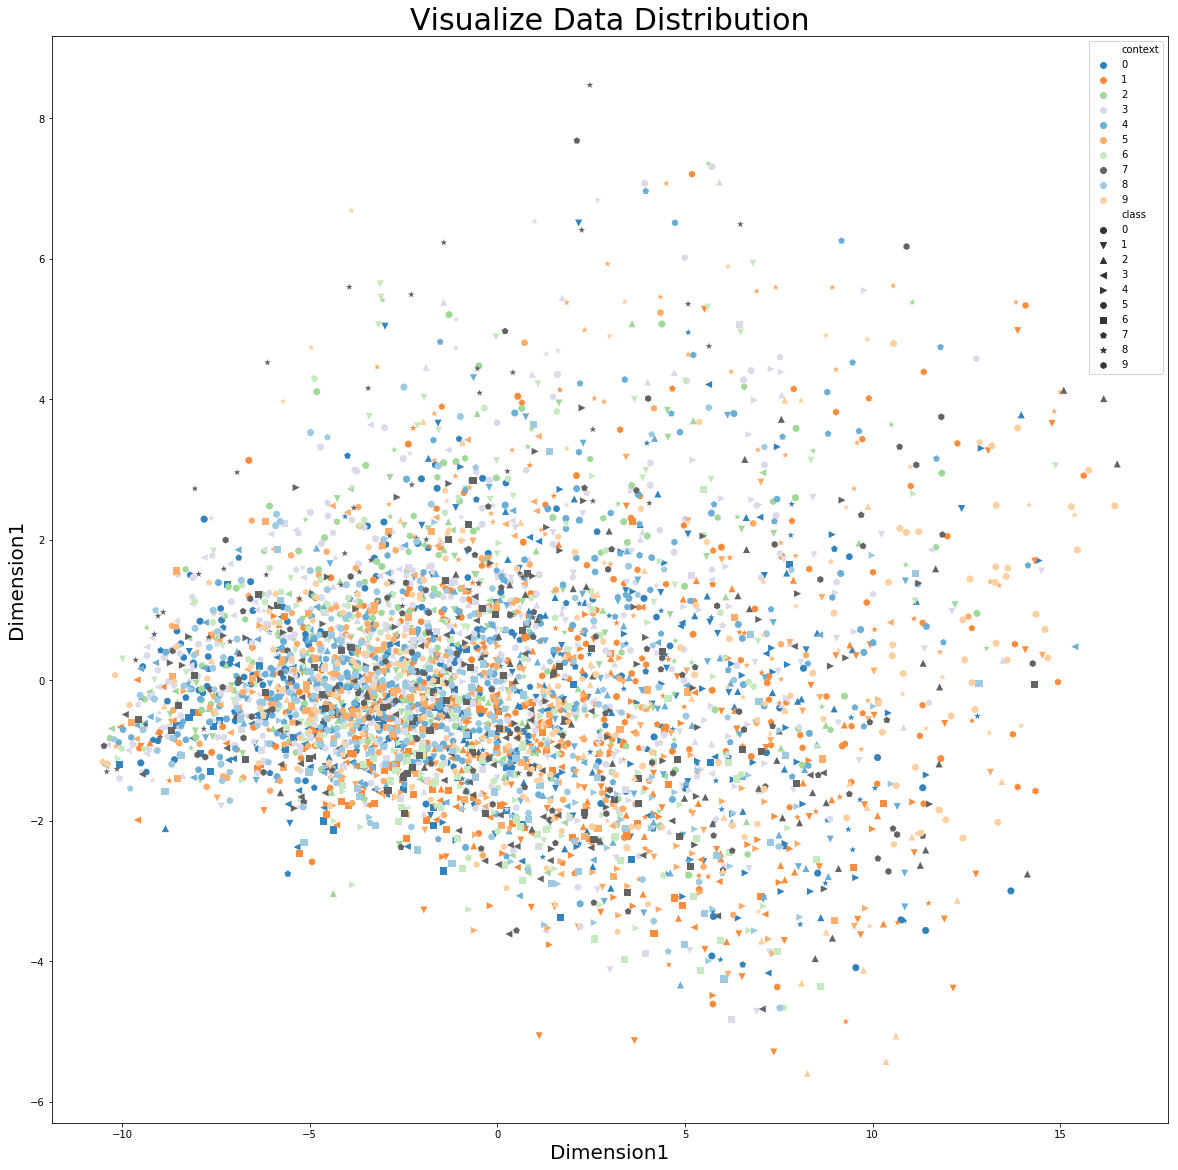

In [41]:
input_table = pd.DataFrame(BoW_Training_x)

fig, ax = plt.subplots(1,figsize=(20,20))
PCA_plot_with_uca_score_sns(ax,input_table.T,class_label,context_label,method='PCA')

ax.set_xlabel('Dimension1',fontsize=20)
ax.set_ylabel('Dimension1',fontsize=20)
ax.set_title('Visualize Data Distribution',fontsize=30)
#fig.savefig(savepath+'RLE with Limma.eps')
#embed_pdf_figure()


In [51]:
get_uca_score(input_table.T,class_label)

[1 6 7 ... 7 4 7]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([149, 538, 413, 187, 761, 192, 300, 941, 314, 361]))


0.16193455245428295

In [47]:
1 - get_knn_score(input_table.T,context_label)

0.9660479186602133

数据并不太按照class聚集，但是也不按照context聚集，

## scale data

In [67]:
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler

In [84]:
X_train = preprocess(X_train,method='robust')[0]
X_test =  preprocess(X_test,method='robust')[0]

## train classifier

In [94]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.svm import SVC

In [85]:
y_train,y_test = y_train[:,0],y_test[:,0]

In [140]:
def Model(width,height,modelname):
    if modelname=='lr':
        model = LogisticRegression()
    elif modelname=='svm':
        model = SVC()
    elif modelname=='xgb':
        model = GradientBoostingClassifier()
    elif modelname=='kn':
        model = neighbors.KNeighborsClassifier(n_neighbors=4, algorithm='brute')
    elif modelname=='rf':
        model = RandomForestClassifier(n_estimators=10,  max_depth=12, n_jobs=5)
    elif modelname=='gp':
        kernel = 1.0 * DotProduct(sigma_0=1.0)**4
        model = GaussianProcessClassifier(kernel = kernel, optimizer=None)
    print (model)
    model.fit(X_train, y_train)
    print ('finish training')
    y_pred = model.predict(X_test)
    
    fig, ax = plt.subplots(1,2,figsize=(width,height))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

In [86]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## evaluate

In [109]:
def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average=None),
           'precision': precision_score(y_test, y_pred,average=None),
           'f1': f1_score(y_test, y_pred,average=None),
           'mcc': matthews_corrcoef(y_test, y_pred)
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))
    return scorers['f1'],scorers['accuracy'],scorers['recall'],scorers['precision'],scorers['mcc']

In [141]:
interact(Model,modelname= Dropdown(options=['lr','svm','xgb','kn','rf','gp'],value='lr'),
                width =FloatSlider(min=12,max=24,step=2,value=15),
                 height= FloatSlider(min=4,max=8,step=2,value=5),
        )

interactive(children=(FloatSlider(value=15.0, description='width', max=24.0, min=12.0, step=2.0), FloatSlider(value=5.0, description='height', max=8.0, min=4.0, step=2.0), Dropdown(description='modelname', options=('lr', 'svm', 'xgb', 'kn', 'rf', 'gp'), value='lr'), Output()), _dom_classes=('widget-interact',))

<function __main__.Model(width, height, modelname)>

## tuning parameters